In [1]:
#### Procesamiento del Lenguaje Natural (NLP) - CECTI - Encuestás

#> Ladino Álvarez Ricardo Arturo

In [1]:
### Librerias

import re
import spacy
import unicodedata
import pandas as pd
from collections import Counter
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from spellchecker import SpellChecker
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('stopwords')

# Cargar el modelo de spaCy en español
nlp = spacy.load("es_core_news_sm")

# Crear el objeto de SpellChecker en español
spell = SpellChecker(language='es')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ricardoarturoladinoa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#### Paths

Entradas = '/Users/ricardoarturoladinoa/Desktop/NLP/'
Salidas = ''

In [3]:
#### Función de Normalización del texto

### Limpieza de texto
def limpiar_texto(texto):

    # > 00 - StopWords
    stop_words = set(stopwords.words('spanish'))
    
    # > 01 - Convertir a minúsculas
    texto = texto.lower()
    
    # > 02 - Eliminar signos de puntuación y números
    texto = re.sub(r'[^\w\s]', '', texto)
    texto = re.sub(r'\d+', '', texto)

    # > 03 - Eliminar acentos y caracteres especiales
    #texto = unicodedata.normalize('NFKD', texto).encode('ascii', 'ignore').decode('utf-8')

    # > 04 Eliminar stopwords
    texto = ' '.join([palabra for palabra in texto.split() if palabra not in stop_words])

    # > 05 Eliminar palabras cortas
    texto = ' '.join([palabra for palabra in texto.split() if len(palabra) > 2])

    # > 06 Corrección ortográfica
    #texto = ' '.join([spell.correction(palabra) for palabra in texto.split()])

    # > 07 Lematización
    texto = ' '.join([token.lemma_ for token in nlp(texto)])

    return (texto)

### Limpieza de múltiples columnas
def limpiar_columnas(df, columnas):
    for columna in columnas:
        df[columna] = df[columna].astype(str).fillna('')  # Convertir a string y manejar NaNs
        df[columna] = df[columna].apply(limpiar_texto)    # Aplicar la función de limpieza completa
    return (df)



##### Frecuencia de palabras

def mapa_frecuencias(df, columna, num_palabras=20, usar_wordcloud=False):
    todo_el_texto = ' '.join(df[columna].dropna().astype(str))
    palabras = todo_el_texto.upper().split()
    contador_palabras = Counter(palabras)
    palabras_comunes = dict(contador_palabras.most_common(num_palabras))
    
    # Convertir las palabras y frecuencias en un DataFrame
    df_palabras_frecuencias = pd.DataFrame(list(palabras_comunes.items()), columns=['Palabra', 'Frecuencia'])
    
    if usar_wordcloud:
        colors = ['#006666', '#990033']
        cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)
        wordcloud = WordCloud(
            width=800,
            height=400,
            background_color='white',
            colormap=cmap,
            prefer_horizontal=1,
            relative_scaling=0.5,
            max_font_size=200,
            random_state=64
        ).generate_from_frequencies(palabras_comunes)
        
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        palabras, frecuencias = zip(*palabras_comunes.items())
        plt.figure(figsize=(10, 5))
        plt.barh(palabras, frecuencias, color='darkred')
        plt.xlabel('Frecuencia')
        plt.ylabel('Palabras')
        plt.title('Frecuencia de palabras más comunes')
        plt.gca().invert_yaxis()
        plt.show()
    
    # Retornar el DataFrame de palabras y frecuencias
    return (df_palabras_frecuencias)


##### StopWords de palabras personalizadas

def normalizar_columnas(df, columnas, stop_words):
    for columna in columnas:
        df[columna] = df[columna].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
    return df

In [4]:
### Lectura de base de datos

ENCUESTAS = pd.read_excel(Entradas + 'New_data.xlsx', sheet_name = 'Base_Nueva') #'Experiencia_Nueva', 'Base_Nueva'
EXPERIENCIA = pd.read_excel(Entradas + 'New_data.xlsx', sheet_name = 'Experiencia_Nueva') #'Experiencia_Nueva', 'Base_Nueva'

In [5]:
### Aplicar función de limpieza de texto

Columnas_BN = ['Uso', 'Deficiencia', 'Herramienta_Ad','Mejoras']  
Columnas_EX = ['Exp_10.6', 'Exp_10.7']

ENCUESTAS = limpiar_columnas(ENCUESTAS, Columnas_BN)
EXPERIENCIA = limpiar_columnas(EXPERIENCIA, Columnas_EX)

In [6]:
#### Diccionario personalizado Parte 1

CECTI_STOP = pd.read_csv("Stop_spanish.txt", header = None, names=["StopWord"])
CECTI_STOP_A = CECTI_STOP['StopWord'].to_numpy()

#### Aplicar funcion de texto stop de forma general

#> Columnas a limpiar

Columns_CBN = ['Uso', 'Deficiencia', 'Herramienta_Ad','Mejoras']
Columns_CEX = ['Exp_10.6', 'Exp_10.7']

#> Función aplicada

ENCUESTAS = normalizar_columnas(ENCUESTAS, Columns_CBN, CECTI_STOP_A)
EXPERIENCIA = normalizar_columnas(EXPERIENCIA, Columns_CEX, CECTI_STOP_A)

In [95]:
#ENCUESTAS.to_excel( 'Experiencia_Nueva_C.xlsx', index=False)

In [ ]:
### Aplicar función de frecuencia de palabras

## Columnas_ = ['Uso', 'Deficiencia', 'Herramienta_Ad','Mejoras'] « ['Exp_10.6', 'Exp_10.7']

#Frecuencias_ = mapa_frecuencias(ENCUESTAS, 'Exp_10.7', num_palabras = 10000, usar_wordcloud = True)
#print(Frecuencias_)

In [87]:
### Exportar palabras y frecuencia para crear diccionario personalizado

#Frecuencias_['Palabra'] = Frecuencias_['Palabra'].str.lower()
#Frecuencias_.to_excel( Entradas + 'Exp_10.7.xlsx', index=False)

### Sección personalizada de stopwords

In [9]:
### Diccionario con los nombres de columnas y sus archivos de stopwords correspondientes

archivos_stopwords = {
    'Uso': 'Uso_Stop.txt',
    'Deficiencia': 'Deficiencia_Stop.txt',
    'Herramienta_Ad': 'Herramienta_Stop.txt',
    'Mejoras': 'Mejoras_Stop.txt',
    'Exp_10.6':'10_6_Stop.txt', 
    'Exp_10.7':'10_7_Stop.txt'
}

# > Cargar los archivos de stopwords y almacenar en un diccionario

stopwords_columnas = {}
for columna, archivo in archivos_stopwords.items():
    stopwords_df = pd.read_csv(archivo, header=None, names=["StopWord"])
    stopwords_columnas[columna] = set(stopwords_df['StopWord'].to_numpy())

In [10]:
# >  Función de normalización de columnas con stopwords específicos personalizada
def normalizar_columna(df, columnas, stopwords_columnas):
    for columna in columnas:
        stop_words = stopwords_columnas.get(columna, set())  # Obtener el conjunto de stopwords para la columna actual
        df[columna] = df[columna].apply(lambda x: ' '.join([word for word in str(x).split() if word not in stop_words]))
    return df


In [12]:
# Columnas a limpiar
Columns_C1 = ['Uso', 'Deficiencia', 'Herramienta_Ad', 'Mejoras']
Columns_C2 = ['Exp_10.6', 'Exp_10.7']

# Aplicar la función de normalización con stopwords específicos (pendiente)
ENCUESTAS = normalizar_columna(ENCUESTAS, Columns_C1, stopwords_columnas)
EXPERIENCIA = normalizar_columna(EXPERIENCIA, Columns_C2, stopwords_columnas)

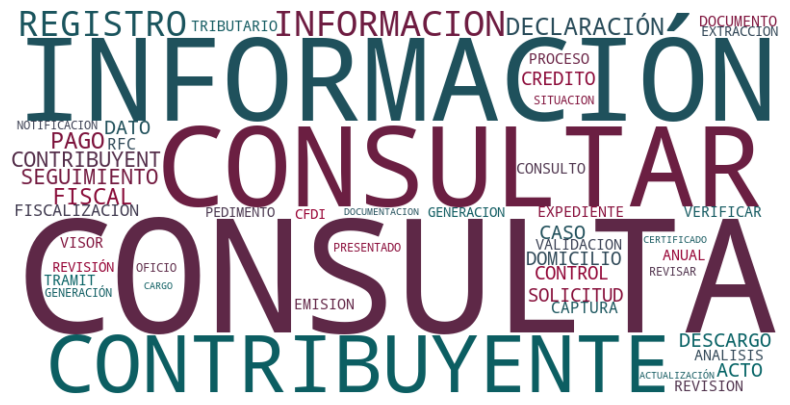

In [17]:
Frecuencias_ = mapa_frecuencias(ENCUESTAS, 'Uso', num_palabras = 50, usar_wordcloud = True)

In [23]:
import pandas as pd
import spacy

# Cargar el archivo de Excel
df = pd.read_excel(Entradas + 'Lemantiza_Dic.xlsx')

# Cargar el modelo de español
nlp = spacy.load("es_core_news_sm")

# Función para lematizar palabras
def lematizar_palabra(palabra):
    doc = nlp(palabra)
    return doc[0].lemma_

# Aplicar la lematización y crear la columna 'Lema'
df['Lema'] = df['Palabra'].apply(lematizar_palabra)

# Guardar el resultado en un nuevo archivo
df.to_excel('Lemantiza_Dic_Con_Lemas.xlsx', index=False)